In [68]:
import pandas as pd
# 시작일과 종료일 설정
start_date = '2024-10-21'
end_date = '2024-10-27'


In [98]:
import pandas as pd

def calculate_metrics_by_date1(filepath, start_date, end_date):
    # 데이터 불러오기
    df = pd.read_excel(filepath)
    
    # 날짜 형식을 변환 (float -> int -> str -> datetime)
    df['날짜'] = pd.to_datetime(df['날짜'].astype(int).astype(str), format='%Y%m%d')
    
    # 시작일과 종료일 범위에 해당하는 데이터 필터링
    filtered_df = df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)]
    
    # 그룹바이하여 데이터 집계
    test_df = filtered_df.groupby('광고 노출 지면')[['노출수','클릭수','총 주문수(1일)','총 전환매출액(1일)','광고비']].sum()

    # 클릭률, 전환률, CPC, ROAS, 전환당비용 추가
    test_df['클릭률'] = round((test_df['클릭수'] / test_df['노출수']) * 100, 2).astype(str) + '%'
    test_df['전환률'] = round((test_df['총 주문수(1일)'] / test_df['클릭수']) * 100, 2).astype(str) + '%'
    test_df['CPC'] = round(test_df['광고비'] / test_df['클릭수'], 2).astype(str) + '원'
    test_df['ROAS'] = round((test_df['총 전환매출액(1일)'] / test_df['광고비']) * 100, 2).astype(str) + '%'
    test_df['전환당비용'] = round(test_df['광고비'] / test_df['총 주문수(1일)'], 2).astype(str) + '원'

    # 컬럼명 변경
    test_df.rename(columns={'총 주문수(1일)': '주문', '총 전환매출액(1일)': '광고매출'}, inplace=True)

    # 전체 합계 행 추가
    total_row = test_df[['노출수', '클릭수', '주문', '광고매출', '광고비']].sum().astype(int)
    total_row['클릭률'] = str(round((total_row['클릭수'] / total_row['노출수']) * 100, 2)) + '%'
    total_row['전환률'] = str(round((total_row['주문'] / total_row['클릭수']) * 100, 2)) + '%'
    total_row['CPC'] = str(round(total_row['광고비'] / total_row['클릭수'], 2)) + '원'
    total_row['ROAS'] = str(round((total_row['광고매출'] / total_row['광고비']) * 100, 2)) + '%'
    total_row['전환당비용'] = str(round(total_row['광고비'] / total_row['주문'], 2)) + '원'

    # "전체"라는 인덱스를 추가하고 concat으로 합치기
    total_row.name = '전체'
    test_df = pd.concat([test_df, total_row.to_frame().T])

    return test_df

# 한글 폰트 설정
plt.rc('font', family='AppleGothic')  # Windows 환경
# 데이터 집계 함수
def calculate_metrics_by_date2(filepath, start_date, end_date):
    df = pd.read_excel(filepath)
    df['날짜'] = pd.to_datetime(df['날짜'].astype(int).astype(str), format='%Y%m%d')
    filtered_df = df[(df['날짜'] >= start_date) & (df['날짜'] <= end_date)]
    
    # 검색 영역과 비검색 영역 매출 및 광고비 집계
    search_df = filtered_df[filtered_df['광고 노출 지면'] == '검색 영역']
    non_search_df = filtered_df[filtered_df['광고 노출 지면'] == '비검색 영역']
    
    search_sales = search_df.groupby('날짜')['총 전환매출액(1일)'].sum()
    non_search_sales = non_search_df.groupby('날짜')['총 전환매출액(1일)'].sum()
    ad_cost = filtered_df.groupby('날짜')['광고비'].sum()
    roas = (filtered_df.groupby('날짜')['총 전환매출액(1일)'].sum() / ad_cost) * 100

    # 결과 데이터프레임 생성
    result_df = pd.DataFrame({
        '검색매출': search_sales,
        '비검색매출': non_search_sales,
        '광고비': ad_cost,
        'ROAS': roas
    }).fillna(0)  # NaN 값을 0으로 대체

    return result_df

# 그래프 그리기 함수
def plot_metrics_over_period(filepath, start_date, end_date):
    # 데이터 준비
    metrics_df = calculate_metrics_by_date2(filepath, start_date, end_date)
    dates = metrics_df.index
    검색매출 = metrics_df['검색매출']
    비검색매출 = metrics_df['비검색매출']
    광고비 = metrics_df['광고비']
    ROAS = metrics_df['ROAS']

    # 그래프 그리기
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # 매출 부분을 막대 그래프로 표시 (검색매출, 비검색매출)
    ax1.bar(dates, 검색매출, label='검색매출', color='skyblue', width=0.6)
    ax1.bar(dates, 비검색매출, bottom=검색매출, label='비검색매출', color='lightgreen', width=0.6)

    # 첫 번째 y축 설정
    ax1.set_ylabel('매출/광고비 (원)', fontsize=12)
    ax1.set_xlabel('날짜', fontsize=12)
    ax1.tick_params(axis='y')

    # 광고비와 ROAS는 꺾은선 그래프로 표시
    ax1.plot(dates, 광고비, color='orange', label='광고비', marker='o', linestyle='-')
    ax2 = ax1.twinx()  # 두 번째 y축 설정
    ax2.plot(dates, ROAS, color='blue', label='ROAS (%)', marker='o', linestyle='-')
    ax2.set_ylabel('ROAS (%)', fontsize=12, color='blue')
    ax2.set_ylim(0, max(ROAS) * 1.2)  # ROAS의 y축 범위 설정

    # 범례 설정
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title(f'{start_date} ~ {end_date} 기간의 매출/광고비 및 ROAS', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [99]:
# 함수 호출 예시
filepath = 'A00910106_pa_daily_keyword_20241021_20241027 (1).xlsx'
start_date = '2024-10-21'
end_date = '2024-10-27'
result = calculate_metrics_by_date1(filepath, start_date, end_date)

# 결과 확인
result

,노출수,클릭수,주문,광고매출,광고비,클릭률,전환률,CPC,ROAS,전환당비용
검색 영역,1745,84,5,39500,53283,4.81%,5.95%,634.32원,74.13%,10656.6원
비검색 영역,476723,264,5,39500,81260,0.06%,1.89%,307.8원,48.61%,16252.0원
전체,478468,348,10,79000,134543,0.07%,2.87%,386.62원,58.72%,13454.3원


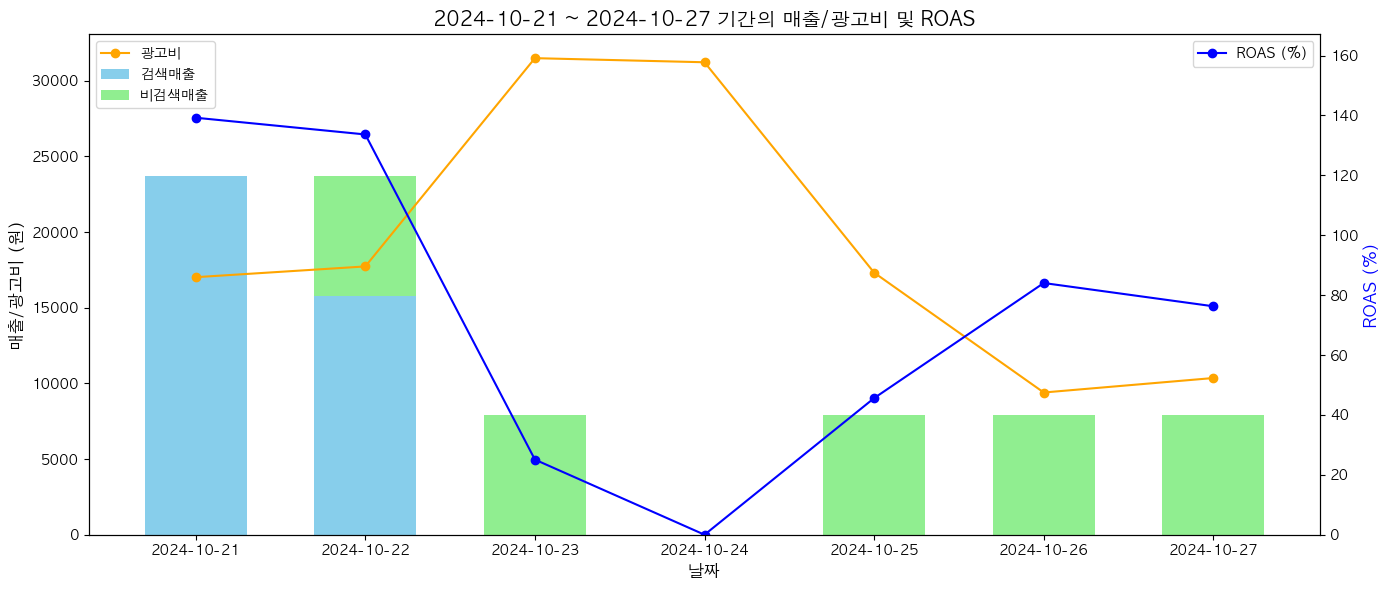

In [100]:

plot_metrics_over_period(filepath, start_date, end_date)

In [109]:

# 그룹바이하여 데이터 집계

test_df = filtered_df.groupby('키워드')[['노출수','클릭수','총 주문수(1일)','총 전환매출액(1일)','광고비']].sum()

# 클릭률, 전환률, CPC, ROAS, 전환당비용 추가
test_df['클릭률'] = round((test_df['클릭수'] / test_df['노출수']) * 100, 2).astype(str) + '%'
test_df['전환률'] = round((test_df['총 주문수(1일)'] / test_df['클릭수']) * 100, 2).astype(str) + '%'
test_df['CPC'] = round(test_df['광고비'] / test_df['클릭수'], 2).astype(str) + '원'
test_df['ROAS'] = round((test_df['총 전환매출액(1일)'] / test_df['광고비']) * 100, 2).astype(str) + '%'
test_df['전환당비용'] = round(test_df['광고비'] / test_df['총 주문수(1일)'], 2).astype(str) + '원'
test_df.sort_values(by='노출수',ascending=False)

,노출수,클릭수,총 주문수(1일),총 전환매출액(1일),광고비,클릭률,전환률,CPC,ROAS,전환당비용
키워드,,,,,,,,,,
넥워머,858,2,0,0,202,0.23%,0.0%,101.0원,0.0%,inf원
겨울 넥워머,267,6,2,15800,4218,2.25%,33.33%,703.0원,374.59%,2109.0원
러닝 넥워머,238,15,2,15800,14167,6.3%,13.33%,944.47원,111.53%,7083.5원
방한 마스크,35,1,0,0,801,2.86%,0.0%,801.0원,0.0%,inf원
방한 넥워머,31,1,0,0,136,3.23%,0.0%,136.0원,0.0%,inf원
군용 목토시,30,3,0,0,866,10.0%,0.0%,288.67원,0.0%,inf원
오토바이 얼굴토시 겨울,20,2,0,0,1364,10.0%,0.0%,682.0원,0.0%,inf원
남자 겨울 목토시,18,3,0,0,2585,16.67%,0.0%,861.67원,0.0%,inf원
목 방한 토시,17,1,0,0,688,5.88%,0.0%,688.0원,0.0%,inf원


In [107]:
test_df.sort_values(by='노출수',ascending=False)

,노출수,클릭수,총 주문수(1일),총 전환매출액(1일),광고비,클릭률,전환률,CPC,ROAS,전환당비용
키워드,,,,,,,,,,
넥워머,858,2,0,0,202,0.23%,0.0%,101.0원,0.0%,inf원
겨울 넥워머,267,6,2,15800,4218,2.25%,33.33%,703.0원,374.59%,2109.0원
러닝 넥워머,238,15,2,15800,14167,6.3%,13.33%,944.47원,111.53%,7083.5원
방한 마스크,35,1,0,0,801,2.86%,0.0%,801.0원,0.0%,inf원
방한 넥워머,31,1,0,0,136,3.23%,0.0%,136.0원,0.0%,inf원
군용 목토시,30,3,0,0,866,10.0%,0.0%,288.67원,0.0%,inf원
오토바이 얼굴토시 겨울,20,2,0,0,1364,10.0%,0.0%,682.0원,0.0%,inf원
남자 겨울 목토시,18,3,0,0,2585,16.67%,0.0%,861.67원,0.0%,inf원
목 방한 토시,17,1,0,0,688,5.88%,0.0%,688.0원,0.0%,inf원
